# 实验4 强化学习(Reforcement Learning)

Author: 高鹏昺

Email: nbgao@126.com

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_style('darkgrid')
%matplotlib inline

# 1. Dynamic Program & Policy Iteratino

## 1.1 Policy Iteration
### Parameters

In [2]:
gamma = 1
reward_size = -1
grid_size = 4
termination_states = [[0,0], grid_size-1, grid_size-1]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
num_iterations = 1000

### Utilities

In [3]:
def action_reward_function(initial_position, action):
    if initial_position in termination_states:
        return initial_position, 0
    reward = reward_size
    final_position = np.array(initial_position) + np.array(action)
    if (-1 in final_position) or (4 in final_position):
        final_position = initial_position
    return final_position, reward

### Initialize

In [4]:
value_map = np.zeros((grid_size, grid_size))
states = [[i, j] for i in range(grid_size) for j in range(grid_size)]
# Step=0: value_map
value_map

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## 1.2 Policy Evaluation

In [5]:
deltas = []
for iter in range(num_iterations):
    copy_value_map = value_map.copy()
    delta_state = []
    for state in states:
        weighted_rewards = 0
        for action in actions:
            final_position, reward = action_reward_function(state, action)
            weighted_rewards += (1/len(actions)*(reward+(gamma*value_map[final_position[0], final_position[1]])))
        delta_state.append(np.abs(copy_value_map[state[0], state[1]] - weighted_rewards))
        copy_value_map[state[0], state[1]] = weighted_rewards
    deltas.append(delta_state)
    
    value_map = copy_value_map
    if iter in [0,1,2,9,99, num_iterations-1]:
        print('Iteration:{}'.format(iter+1))
        print(value_map)

Iteration:1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]
Iteration:2
[[ 0.   -1.75 -2.   -2.  ]
 [-1.75 -2.   -2.   -2.  ]
 [-2.   -2.   -2.   -2.  ]
 [-2.   -2.   -2.   -2.  ]]
Iteration:3
[[ 0.     -2.4375 -2.9375 -3.    ]
 [-2.4375 -2.875  -3.     -3.    ]
 [-2.9375 -3.     -3.     -3.    ]
 [-3.     -3.     -3.     -3.    ]]
Iteration:10
[[ 0.         -6.28381348 -8.68228149 -9.48358154]
 [-6.28381348 -8.09024048 -9.21368408 -9.66893005]
 [-8.68228149 -9.21368408 -9.64501953 -9.84373474]
 [-9.48358154 -9.66893005 -9.84373474 -9.93212891]]
Iteration:100
[[  0.         -26.09141026 -39.13065581 -44.74768574]
 [-26.09141026 -35.45329583 -43.02928474 -46.91675657]
 [-39.13065581 -43.02928474 -47.14615743 -49.55722337]
 [-44.74768574 -46.91675657 -49.55722337 -51.23249022]]
Iteration:1000
[[  0.         -29.99999994 -45.14285705 -51.71428561]
 [-29.99999994 -40.85714278 -49.71428561 -54.28571417]
 [-45.14285705 -49.71428561 -54.57142846 -57.42857131]
 [-5

deltas shape: (1000, 16)


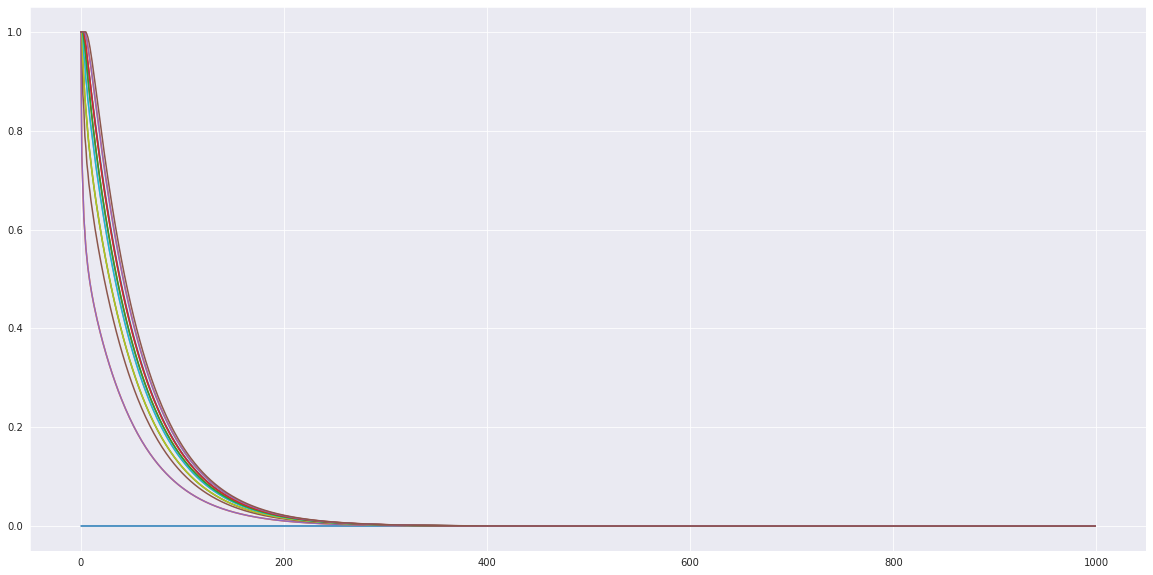

In [12]:
print('deltas shape:', np.shape(deltas))
plt.figure(figsize=(20,10))
plt.plot(deltas);

# 2. Monte Carlo Approximation

### Parameters

In [53]:
gamma = 0.6
reward_size = -1
grid_size = 4
terminaton_states = [[0,0], [grid_size-1, grid_size-1]]
actions = [[-1,0], [1,0], [0,1], [0,-1]]
num_iterations = 1000

### Initialize

In [54]:
V = np.zeros((grid_size, grid_size))
returns = {(i,j): list() for i in range(grid_size) for j in range(grid_size)}
deltas = {(i,j): list() for i in range(grid_size) for j in range(grid_size)}
states = [[i,j] for i in range(grid_size) for j in range(grid_size)]

### Utilities

In [55]:
def generate_episode():
    init_state = random.choice(states[1:-1])
    episode = []
    while True:
        if list(init_state) in termination_states:
            return episode
        action = random.choice(actions)
        final_state = np.array(init_state) + np.array(action)
        if (-1 in list(final_state)) or (grid_size in list(final_state)):
            final_state = init_state
        episode.append([list(init_state), action, reward_size, list(final_state)])
        init_state = final_state

In [56]:
for iter in tqdm(range(num_iterations)):
    episode = generate_episode()
    G = 0
    for i, step in enumerate(episode[::-1]):
        G = gamma*G + step[2]
        if step[0] not in [x[0] for x in episode[::-1][len(episode)-i:]]:
            idx = (step[0][0], step[0][1])
            returns[idx].append(G)
            new_value = np.average(returns[idx])
            deltas[idx[0], idx[1]].append(np.abs(V[idx[0], idx[1]]-new_value))
            V[idx[0], idx[1]] = new_value

100%|██████████| 1000/1000 [00:00<00:00, 1101.89it/s]


In [51]:
V

array([[  0.        ,  -6.16435826, -12.32932166, -16.79555556],
       [ -8.36625514,  -8.64506481, -11.77725118, -16.72076789],
       [-10.76531792, -12.17403709, -13.92997812, -18.96998124],
       [-17.87025704, -16.32081377, -17.32768362, -21.51470588]])

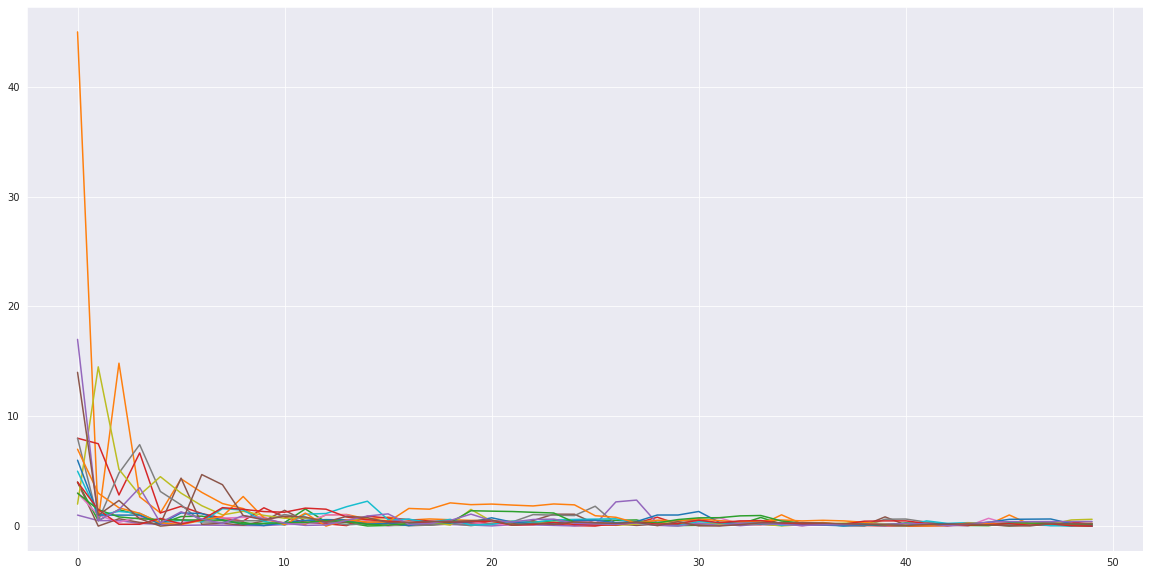

In [52]:
# gamma = 1
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)

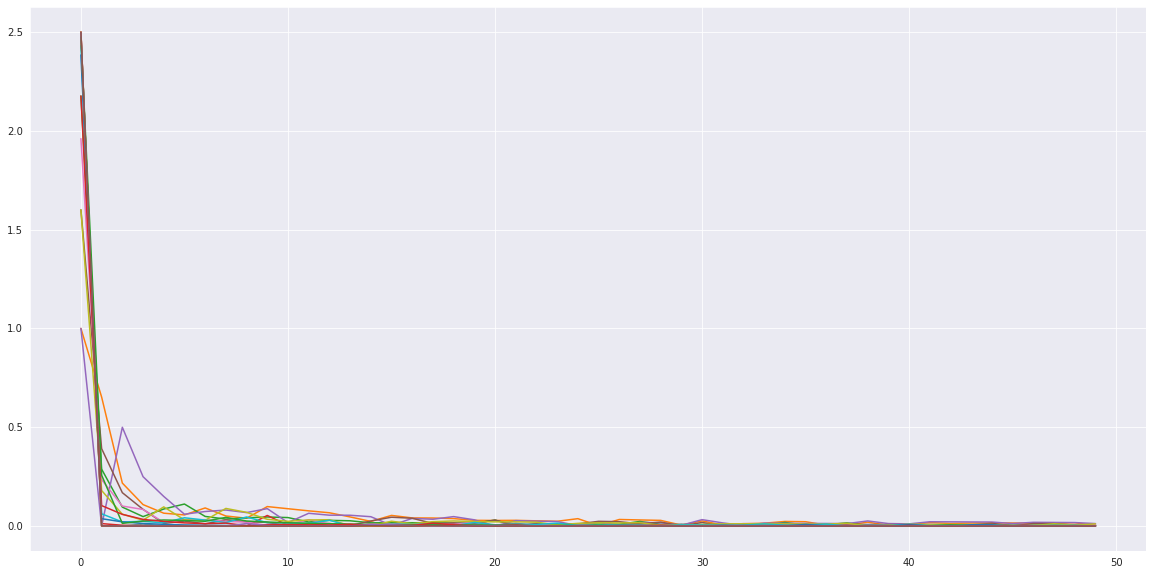

In [58]:
# gamma = 0.6
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)

# 3. Time Difference Learning

### Parameters

In [90]:
gamma = 0.1
reward_size = -1
grid_size = 4
alpha = 0.1  # step_size
termination_states = [[0,0], [grid_size-1, grid_size-1]]
actions = [[-1,0],[1,0],[0,1],[0,-1]]
num_iterations = 10000

### Initialize

In [91]:
V = np.zeros((grid_size, grid_size))
returns = {(i,j):list() for i in range(grid_size) for j in range(grid_size)}
deltas = {(i,j):list() for i in range(grid_size) for j in range(grid_size)}
states = [[i,j] for i in range(grid_size) for j in range(grid_size)]

### Utilities

In [92]:
def generate_initial_state():
    init_state = random.choice(states[1:-1])
    return init_state

def generate_next_action():
    return random.choice(actions)

def take_action(state, action):
    if list(state) in termination_states:
        return 0, None
    final_state = np.array(state) + np.array(action)
    if (-1 in list(final_state)) or (grid_size in list(final_state)):
        final_state = state
    return reward_size, list(final_state)

In [93]:
for iter in tqdm(range(num_iterations)):
    state = generate_initial_state()
    while True:
        action = generate_next_action()
        reward, final_state = take_action(state, action)
        if final_state is None:
            break
        before = V[state[0], state[1]]
        V[state[0], state[1]] += alpha*(reward+gamma*V[final_state[0], final_state[1]]-V[state[0], state[1]])
        deltas[state[0], state[1]].append(float(np.abs(before-V[state[0], state[1]])))
        state = final_state

100%|██████████| 10000/10000 [00:01<00:00, 5300.39it/s]


In [68]:
V

array([[ 0.        , -1.11758496, -1.99508604, -1.9900663 ],
       [-1.97873081, -1.80181154, -1.9937392 , -1.91591425],
       [-1.99482774, -1.98167876, -1.98240426, -1.48053407],
       [-1.97146175, -1.87723881, -1.9018885 ,  0.        ]])

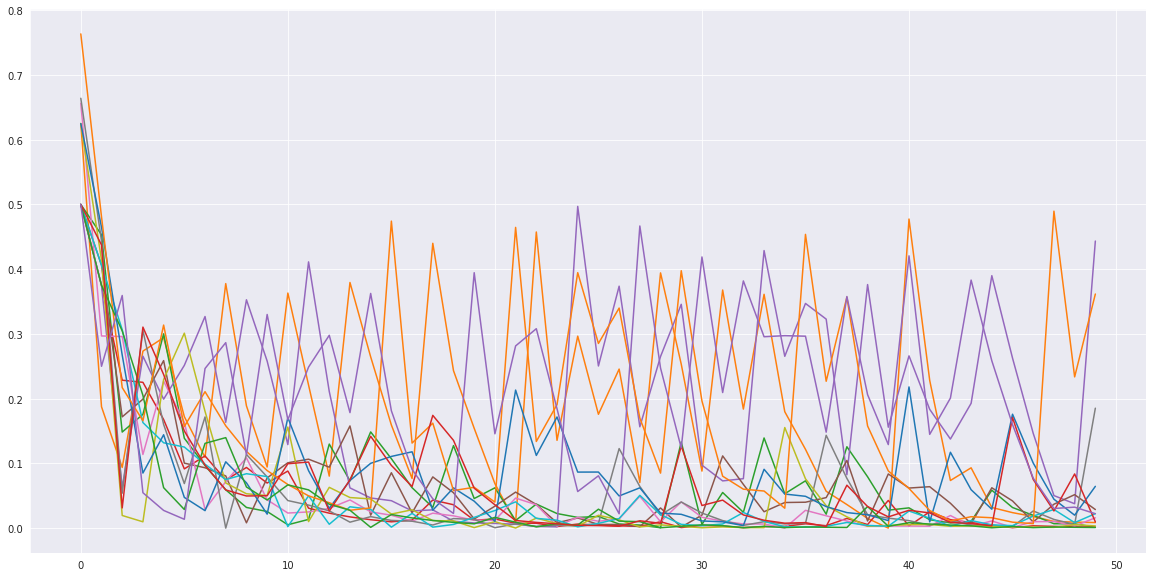

In [69]:
# gamma = 0.5  alpha = 0.5
# Not convergent
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)

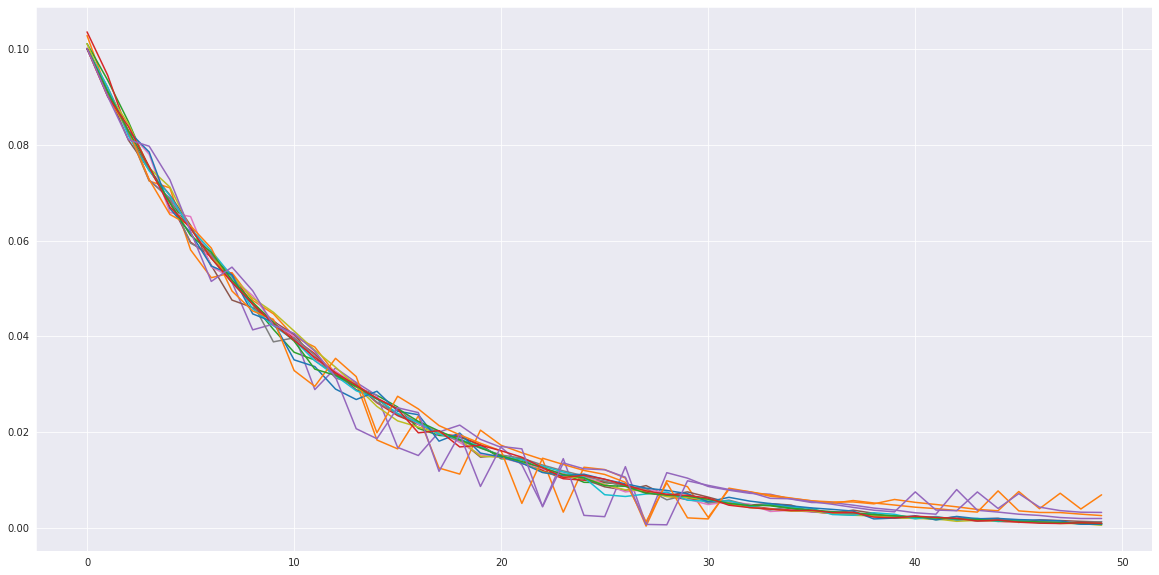

In [94]:
# gamma = 0.1  alpha = 0.1
# Convergent
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)